## Requirements: -

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

## Data Collection

In [54]:
splits = {'train': 'emoji/train-00000-of-00001.parquet', 'test': 'emoji/test-00000-of-00001.parquet', 'validation': 'emoji/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/cardiffnlp/tweet_eval/" + splits["train"])

In [55]:
df.sample(10)

,text,label
9055,@user Men Of The Year for @user #johnphotograp...,18
2102,PinkMoon Shea Butter whip is a tubeful of suns...,3
27922,New photos #portacreative @ Porta Creative,18
5351,so happy to spend time with my beautiful Aus c...,0
44136,#fashion #passion food &amp; #friendship is wh...,0
30640,#explorecalifornia #stoneypoint #nikon @ Stone...,0
19210,Look at all the cheesecake @ The Cheesecake Fa...,1
32972,Can' t wait to the famous night show of these ...,16
43895,The 2nd my home palm spring #home #palm spring...,0
18199,Happy National BBQ Month!! Recently found some...,14


In [56]:
df.shape

(45000, 2)

### Checking for Null Values & Duplicates

In [57]:
df.isnull().sum()

,0
text,0
label,0


In [58]:
df.duplicated().sum()

np.int64(337)

In [59]:
df.drop_duplicates(inplace=True)

### Distribtion of Label

/tmp/ipython-input-1914902968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label',data=df , palette='pastel')


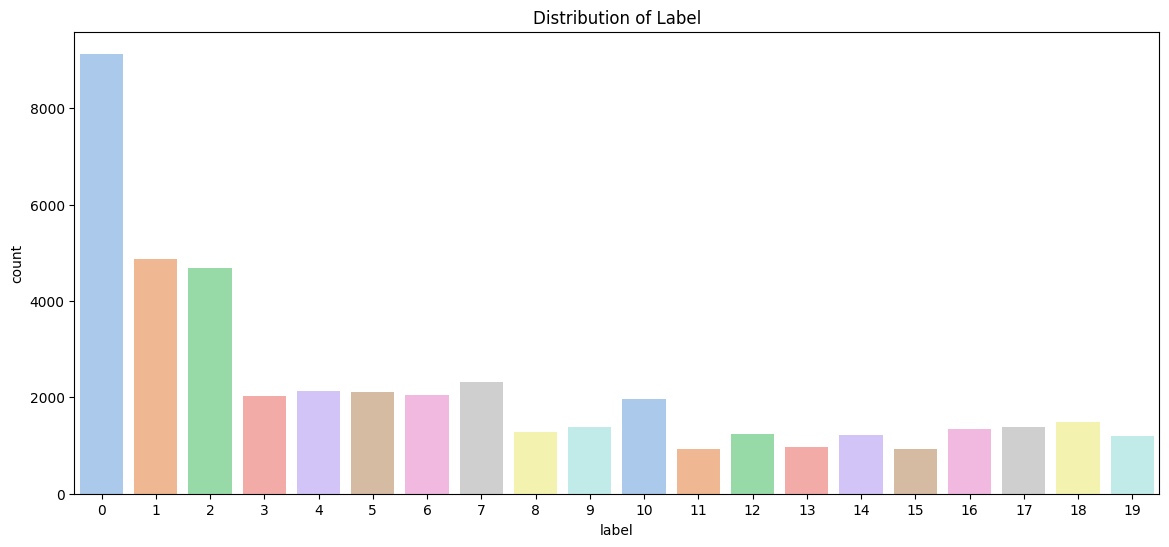

In [60]:
plt.figure(figsize=(14,6))
sns.countplot(x='label',data=df , palette='pastel')
plt.title("Distribution of Label")
plt.show()

### Sampling only 3 classes out of 20

In [61]:
three_labels = [0, 1, 2]

filtered_df = df[df["label"].isin(three_labels)]

sample_df = filtered_df.sample(n=1000, random_state=42)

### Dataset Shape After

In [62]:
sample_df.shape

(1000, 2)

In [63]:
sample_df.head()

,text,label
5529,Thankful for so much on this wonderful holiday...,0
18338,"Strong mind, soft heart. Healthy body, happy s...",0
609,#littlebeachhousemalibu # ️la @ Little Beach H...,0
15300,️Love this woman and all she stands for. Frien...,0
11722,️ @ Golden Gate Bridge Lookout,0


### Visualizing classes after sampling

/tmp/ipython-input-223766861.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=sample_df, palette='pastel')


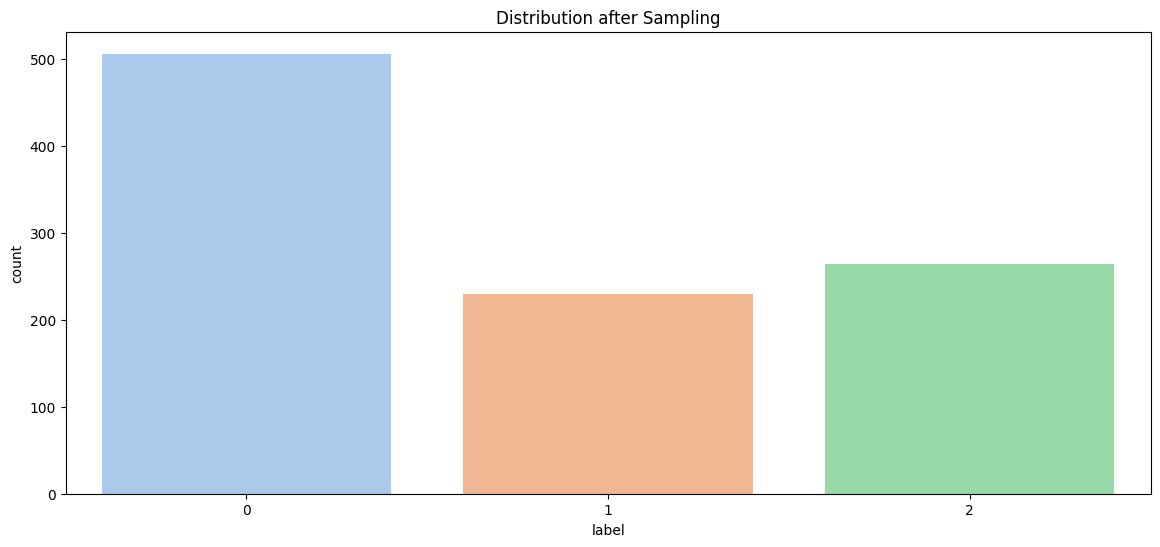

In [64]:
plt.figure(figsize=(14,6))
sns.countplot(x='label', data=sample_df, palette='pastel')
plt.title("Distribution after Sampling")
plt.show()

### Text Preprocessing

In [65]:
def clean_text(text):
    text = text.lower() # lowercasing
    text = re.sub(r"<.*?>", " ", text) # removing HTML tags
    text = re.sub(r"[^\x00-\x7F]+", " ", text) # removing emojis & non-ascii characters
    text = re.sub(r"\d+", " ", text) # remove numbers
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", " ", text) # removing extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

### Applying the Function to text

In [66]:
sample_df['text'] = sample_df['text'].apply(clean_text)

In [67]:
sample_df.head(10)

,text,label
5529,thankful for so much on this wonderful holiday...,0
18338,"strong mind, soft heart. healthy body, happy s...",0
609,littlebeachhousemalibu la little beach house m...,0
15300,love this woman and all she stands for. friend...,0
11722,golden gate bridge lookout,0
2521,coldplay! thank you user rosebowl vip suites,0
8579,oh my! i forgot to post about run yesterday we...,2
27946,yass the full like up for hsmf is out,1
6234,user was my favorite part of hard. goodvibes h...,1
18327,thanks for playing my song beautiful beverly h...,0


In [68]:
sample_df.to_json("corpus.json", orient='records', lines=False, force_ascii=False, index=False)

## Installing Dependencies

In [69]:
!pip install transformers sentence-transformers faiss-cpu streamlit gradio

## Initializing Model

In [70]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

id2label = model.config.id2label
print(id2label)


{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}


## Loading Data

In [71]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

df = pd.read_json("corpus.json")

### Testing the Model on the Dataset

In [72]:
label_map = {
    0: "positive",   # dataset's 0 → positive
    1: "neutral",    # dataset's 1 → neutral
    2: "negative"    # dataset's 2 → negative
}
df["label"] = df["label"].map(label_map)

# 3. Load model
classifier = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment"
)

# 4. Predict
preds = classifier(df["text"].tolist(), batch_size=32)

# 5. Convert model predictions (LABEL_0, LABEL_1, LABEL_2 → strings)
model_map = {0: "negative", 1: "neutral", 2: "positive"}
df["predicted"] = [model_map[int(p["label"].replace("LABEL_", ""))] for p in preds]

# 6. Evaluate
y_true = df["label"].tolist()
y_pred = df["predicted"].tolist()

print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("\n✅ Report:\n", classification_report(y_true, y_pred))

Device set to use cuda:0


✅ Accuracy: 0.431

✅ Report:
               precision    recall  f1-score   support

    negative       0.75      0.17      0.28       264
     neutral       0.22      0.43      0.29       230
    positive       0.59      0.57      0.58       506

    accuracy                           0.43      1000
   macro avg       0.52      0.39      0.38      1000
weighted avg       0.55      0.43      0.43      1000



## Save Model

In [73]:
classifier.model.save_pretrained('saved_model')

### Defining the texts to test the model on

In [74]:
texts = [
    "I love this product! It works perfectly.",
    "This is the worst movie I’ve ever watched.",
    "Meh, it was okay, nothing special.",
    "Absolutely fantastic experience, highly recommend!",
    "I am so disappointed, total waste of money.",
    "It’s fine, I don’t really care much.",
    "Amazing service, the staff was very friendly!",
    "Terrible idea, I regret trying this.",
    "Not bad, but not great either.",
    "Best purchase I’ve made this year!"
]

### Model Classifying the texts

In [75]:
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

classifier = pipeline(
    'sentiment-analysis',
    model='saved_model',
    tokenizer='cardiffnlp/twitter-roberta-base-sentiment'
)

preds = classifier(texts)

for text, pred in zip(texts, preds):
  sentiment = label_map[pred['label']]
  print(f"{text}")
  print(f"Predicted: {sentiment} (score={pred['score']:.4f})\n")

Device set to use cuda:0


I love this product! It works perfectly.
Predicted: positive (score=0.9920)

This is the worst movie I’ve ever watched.
Predicted: negative (score=0.9647)

Meh, it was okay, nothing special.
Predicted: positive (score=0.7213)

Absolutely fantastic experience, highly recommend!
Predicted: positive (score=0.9830)

I am so disappointed, total waste of money.
Predicted: negative (score=0.9803)

It’s fine, I don’t really care much.
Predicted: neutral (score=0.4766)

Amazing service, the staff was very friendly!
Predicted: positive (score=0.9874)

Terrible idea, I regret trying this.
Predicted: negative (score=0.9775)

Not bad, but not great either.
Predicted: negative (score=0.6046)

Best purchase I’ve made this year!
Predicted: positive (score=0.9717)



### Pros:
#### 📌 The Model Used is already pretained on positive, negative, neutral sentiments which makes it easier on this data.
#### 📌 Even though accuracy & f1_scores may issue bad performance, but the model acts familiar with sentiments.
### cons:
#### 📌 High imbalance towards positive class due to high tweets in that class, issue can be solved using smote or class weights.
#### 📌 That imbalance may issue an overlap between negative & neutral

## Loading Data for Embedding

In [76]:
import json

with open('corpus.json', 'r', encoding='utf-8') as f:
  data = json.load(f)


sentiment_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

documents = [item['text'] for item in data]
labels = [sentiment_map[item["label"]] for item in data]

## Initializing Sentence Model

In [77]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(documents, convert_to_tensor=True)

print("Embedding Shape: ", embeddings.shape)

Embedding Shape:  torch.Size([1000, 384])


## Vector DB

In [78]:
import faiss

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings.cpu().numpy())

emotion_model = pipeline(
    'sentiment-analysis',
    model = '/content/saved_model',
    tokenizer=tokenizer,
    top_k = None
)

Device set to use cuda:0


### retrieve function

In [84]:
def retrieve_responses(query, k=3):
    emotion_pred = emotion_model(query)[0]
    sentiment_map = {
        "LABEL_0": "negative",
        "LABEL_1": "neutral",
        "LABEL_2": "positive"
    }
    detected_emotion = sentiment_map[max(emotion_pred, key=lambda x: x['score'])['label']]

    query_emb = model.encode([query], convert_to_numpy=True)

    D, I = index.search(query_emb, k*5)

    candidates = [(documents[i], labels[i], D[0][j]) for j, i in enumerate(I[0])]

    filtered = [c for c in candidates if c[1] == detected_emotion]

    results = (filtered[:k] if len(filtered) >= k else candidates[:k])

    return detected_emotion, results

In [85]:
query = 'i feel sad and heartbroken today!'
emotion, response = retrieve_responses(query, k=3)

print(f"Detected Emotion: {emotion}")
for i , (text, label, dist) in enumerate(response, 1):
  print(f"{i}, {text} [{label}] (distance={dist: 4f})")

Detected Emotion: negative
1, home is where the heart is i just wanted to take a moment amp say how grateful i truly am [negative] (distance= 0.995846)
2, from time to time my heart feels like it is going to explode, but not to worry, it s all from [negative] (distance= 1.043151)
3, but what fills my heart most is the special time we share with familia and friends! merry [negative] (distance= 1.198942)


### generate response function

In [86]:
def generate_response(user_input):
    emotion, responses = retrieve_responses(user_input, k=3)

    templates = "\n".join([f"- {r[0]}" for r in responses])
    prompt = (
        f"The user is feeling {emotion}. "
        f"Final response:"
    )

    final_response = f"{prompt}\n\n I'M a Emotion Analyst."

    return final_response

### Chatbot Response

In [87]:

print("Chatbot ready! Type 'quit' to exit.\n")

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit"]:
        break

    response = generate_response(user_input)
    print("\nBot:", response, "\n")


Chatbot ready! Type 'quit' to exit.

You: i hate his product

Bot: The user is feeling negative. Final response:

 I'M a Emotion Analyst. 

You: i'm not oay

Bot: The user is feeling negative. Final response:

 I'M a Emotion Analyst. 

You: quit


## Deployment Using Streamlit & Gradio

In [88]:
%%writefile app.py
import streamlit as st

st.title("🧠 Emotion Analysis RAG Chatbot")
st.write("Enter a message and get empathetic responses (positive, negative, neutral).")

user_input = st.text_area("Your message:")

if st.button("Get Response"):
    if user_input.strip():
        response = generate_response(user_input)
        st.write("### 🤖 Bot Response")
        st.write(response)

Writing app.py


In [89]:
import gradio as gr

demo = gr.Interface(
    fn=generate_response,
    inputs=gr.Textbox(label="Enter your message"),
    outputs=gr.Textbox(label="Chatbot Response"),
    title="🧠 Emotion-Aware RAG Chatbot",
    description="Classifies your input as positive/neutral/negative and retrieves empathetic responses."
)
if __name__ == "__main__":
  demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8aa485a1d6e7902bc5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
